In [8]:
import os
import numpy as np
import pandas as pd

DATA_PATH = "../data/processed/financial_ratios_final_clean.csv"
REP_PATH  = "../outputs/tables/representative_indicators_by_industry_year.csv"
OUT_DIR   = "../outputs/tables"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")
rep = pd.read_csv(REP_PATH, encoding="utf-8-sig")

# Pivot rep -> wide
REP_COL = "Chỉ số đại diện (theo PCA)"
rep_wide = (
    rep.pivot_table(
        index=["Ngành ICB - cấp 1", "Năm"],
        columns="Nhóm chỉ số",
        values=REP_COL,
        aggfunc="first"
    )
    .reset_index()
)

expected_groups = ["Liquidity", "Leverage", "Efficiency", "Profitability"]
missing_groups = [g for g in expected_groups if g not in rep_wide.columns]
if missing_groups:
    raise ValueError(f"Thiếu nhóm trong rep_wide: {missing_groups}. Kiểm tra file 03.")

df_base = df.merge(rep_wide, on=["Ngành ICB - cấp 1", "Năm"], how="inner")
print("df_base:", df_base.shape)

base_path = os.path.join(OUT_DIR, "05A_base_with_representatives.csv")
df_base.to_csv(base_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", base_path)

df_base: (1469, 24)
✅ Saved: ../outputs/tables/05A_base_with_representatives.csv


In [9]:
import os
import numpy as np
import pandas as pd

IN_PATH = "../outputs/tables/05A_base_with_representatives.csv"
OUT_DIR = "../outputs/tables"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_PATH, encoding="utf-8-sig")

expected_groups = ["Liquidity", "Leverage", "Efficiency", "Profitability"]

bench_rows = []

for (industry, year), g in df.groupby(["Ngành ICB - cấp 1", "Năm"]):

    # KHÔNG loại bỏ ngành/năm vì ít dòng
    # (Nếu vẫn muốn bảo vệ, dùng <1 là vô nghĩa vì groupby luôn >=1)
    # if g.shape[0] < 1:
    #     continue

    for group in expected_groups:
        ind_name = g[group].iloc[0]  # tên chỉ số đại diện (có thể NaN)

        # Nếu PCA không ra indicator => vẫn ghi row để không mất ngành/năm/nhóm
        if pd.isna(ind_name) or ind_name not in df.columns:
            bench_rows.append({
                "Ngành ICB - cấp 1": industry,
                "Năm": year,
                "Nhóm chỉ số": group,
                "Indicator_Name": ind_name if not pd.isna(ind_name) else np.nan,
                "Benchmark_Mean": np.nan,
                "n_obs": 0
            })
            continue

        vals = pd.to_numeric(g[ind_name], errors="coerce")
        n_obs = int(vals.notna().sum())

        # Nếu không có quan sát hợp lệ => vẫn ghi row (mean = NaN)
        bench_rows.append({
            "Ngành ICB - cấp 1": industry,
            "Năm": year,
            "Nhóm chỉ số": group,
            "Indicator_Name": ind_name,
            "Benchmark_Mean": vals.mean(skipna=True) if n_obs > 0 else np.nan,
            "n_obs": n_obs
        })

bench_df = pd.DataFrame(bench_rows)
print("bench_df:", bench_df.shape)

bench_path = os.path.join(OUT_DIR, "05B_industry_year_benchmarks.csv")
bench_df.to_csv(bench_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", bench_path)

bench_df: (160, 6)
✅ Saved: ../outputs/tables/05B_industry_year_benchmarks.csv


/tmp/ipykernel_15411/697707397.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap("YlGnBu")


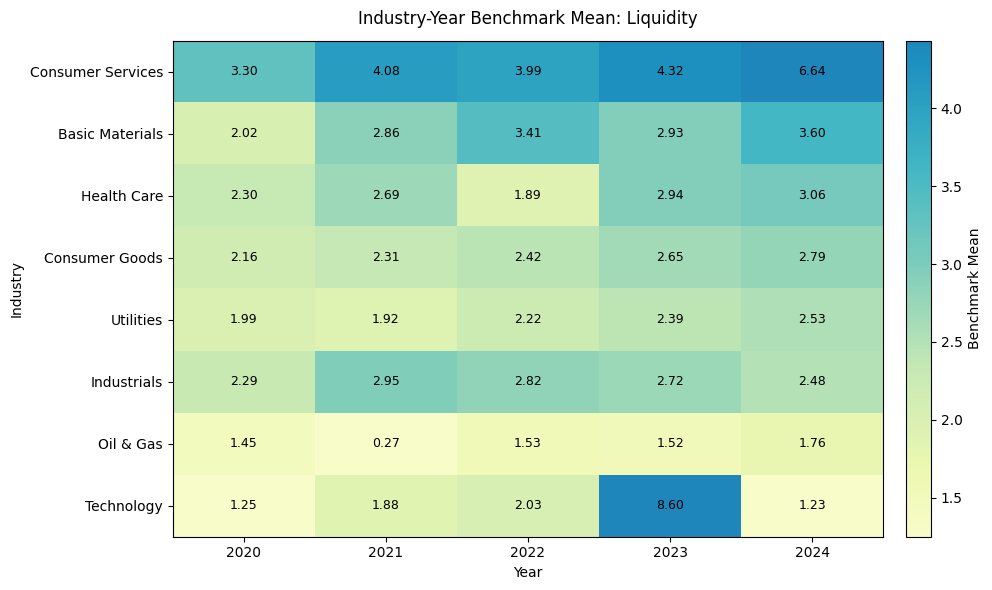

Saved: ../outputs/figures/heatmap_benchmark_Liquidity.png


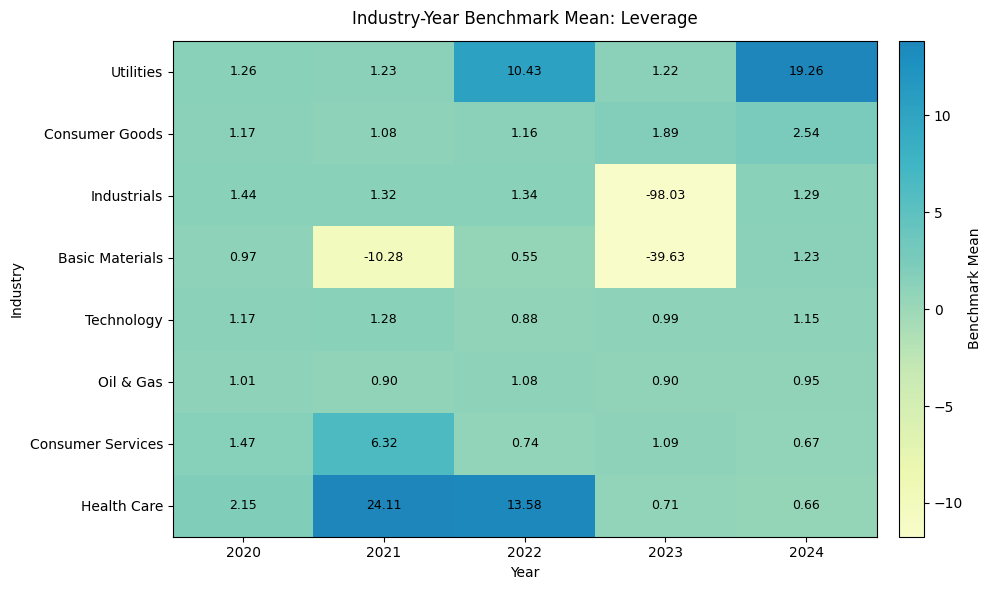

Saved: ../outputs/figures/heatmap_benchmark_Leverage.png


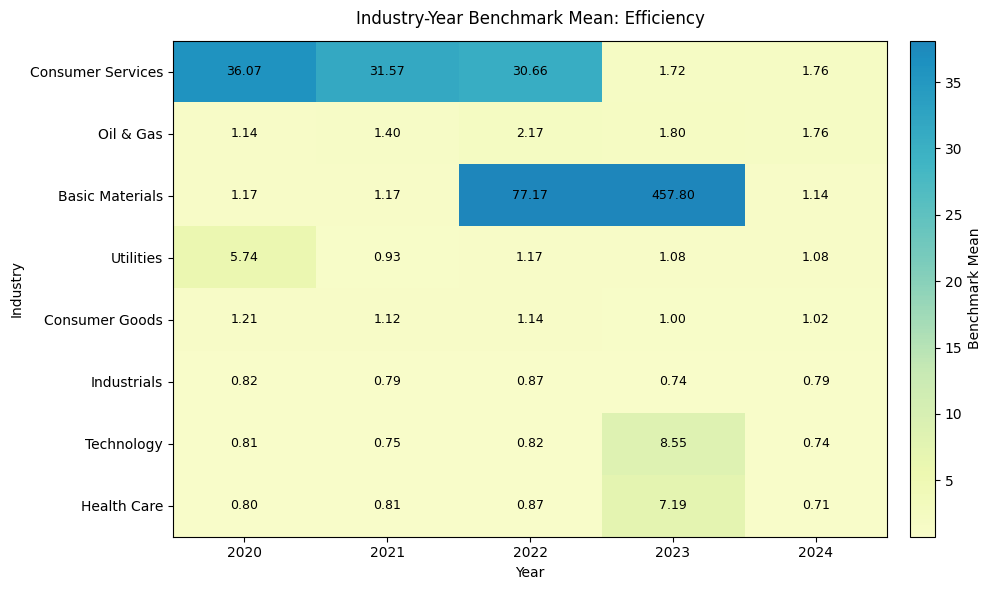

Saved: ../outputs/figures/heatmap_benchmark_Efficiency.png


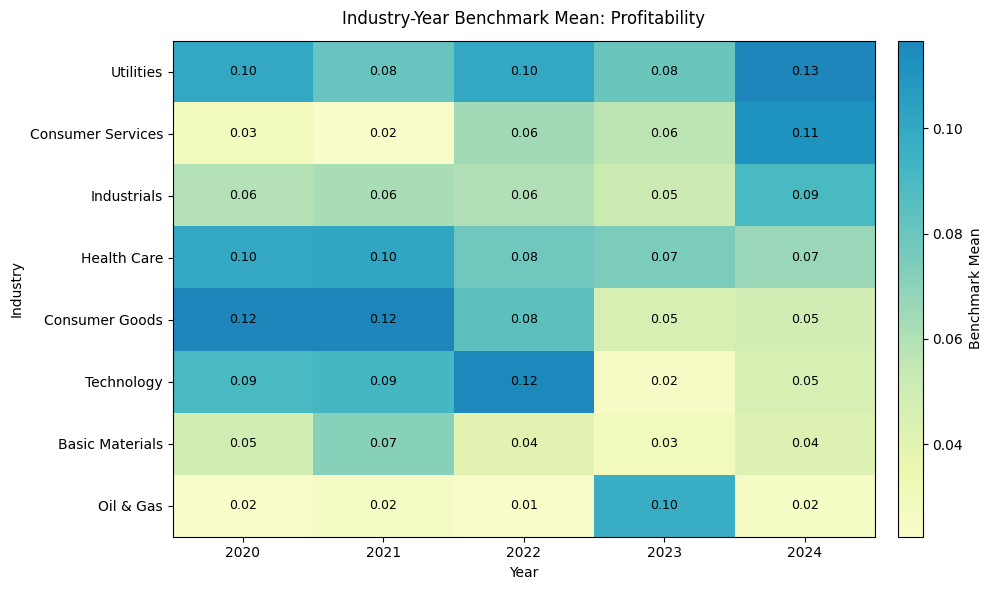

Saved: ../outputs/figures/heatmap_benchmark_Profitability.png


In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# =========================
# Paths
# =========================
BENCH_PATH = "../outputs/tables/05B_industry_year_benchmarks.csv"
FIG_DIR = "../outputs/figures"
os.makedirs(FIG_DIR, exist_ok=True)

bench_df = pd.read_csv(BENCH_PATH, encoding="utf-8-sig")

# =========================
# Industry name mapping (VN -> EN)
# =========================
INDUSTRY_MAP = {
    "Dầu khí": "Oil & Gas",
    "Nguyên vật liệu": "Basic Materials",
    "Công nghiệp": "Industrials",
    "Hàng Tiêu dùng": "Consumer Goods",
    "Dược phẩm và Y tế": "Health Care",
    "Dịch vụ Tiêu dùng": "Consumer Services",
    "Viễn thông": "Telecommunications",
    "Tiện ích Cộng đồng": "Utilities",
    "Tài chính": "Financials",
    "Ngân hàng": "Banks",
    "Công nghệ Thông tin": "Technology"
}

bench_df["Industry_EN"] = (
    bench_df["Ngành ICB - cấp 1"]
      .astype(str)
      .str.strip()
      .map(INDUSTRY_MAP)
      .fillna(bench_df["Ngành ICB - cấp 1"].astype(str).str.strip())
)

groups = ["Liquidity", "Leverage", "Efficiency", "Profitability"]

# =========================
# Lighter colormap for clearer numbers
# =========================
# Use a truncated, lighter range of YlGnBu (avoid dark end)
base = mpl.cm.get_cmap("YlGnBu")
light_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "YlGnBu_light",
    base(np.linspace(0.05, 0.65, 256))
)
light_cmap.set_bad(color="#F2F2F2")  # NaN cells

def plot_heatmap_for_group(bench_df, group_name, out_dir):
    df_g = bench_df[bench_df["Nhóm chỉ số"] == group_name].copy()

    heat = df_g.pivot(index="Industry_EN", columns="Năm", values="Benchmark_Mean")
    heat = heat.reindex(sorted(heat.columns), axis=1)

    # Sort industries by last year if possible (helps readability)
    last_year = heat.columns.max()
    if pd.notna(last_year):
        heat = heat.sort_values(by=last_year, ascending=False)
    else:
        heat = heat.sort_index()

    data = heat.values.astype(float)
    valid = data[np.isfinite(data)]

    # Robust scaling so a few extremes won't wash out the palette
    if valid.size > 0:
        vmin, vmax = np.nanpercentile(valid, [5, 95])
        if np.isclose(vmin, vmax):
            vmin, vmax = np.nanmin(valid), np.nanmax(valid)
    else:
        vmin, vmax = 0, 1

    masked = np.ma.masked_invalid(data)

    fig_w = max(10, 1.2 * len(heat.columns))
    fig_h = max(6, 0.55 * len(heat.index))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(masked, aspect="auto", cmap=light_cmap, vmin=vmin, vmax=vmax)

    ax.set_title(f"Industry-Year Benchmark Mean: {group_name}", pad=12)
    ax.set_xlabel("Year")
    ax.set_ylabel("Industry")

    ax.set_xticks(np.arange(len(heat.columns)))
    ax.set_xticklabels([str(c) for c in heat.columns])

    ax.set_yticks(np.arange(len(heat.index)))
    ax.set_yticklabels([str(i) for i in heat.index])

    # Annotate values (black text for clarity on light colors)
    for i in range(masked.shape[0]):
        for j in range(masked.shape[1]):
            val = masked[i, j]
            if np.ma.is_masked(val):
                continue
            ax.text(j, i, f"{float(val):.2f}", ha="center", va="center", fontsize=9, color="black")

    cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.03)
    cbar.set_label("Benchmark Mean")

    plt.tight_layout()
    out_path = os.path.join(out_dir, f"heatmap_benchmark_{group_name}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print("Saved:", out_path)

for g in groups:
    plot_heatmap_for_group(bench_df, g, FIG_DIR)

In [25]:
import pandas as pd

# 1) Từ dữ liệu gốc (đầu pipeline)
DATA_PATH = "../data/processed/financial_ratios_final_clean.csv"
df0 = pd.read_csv(DATA_PATH, encoding="utf-8-sig")

base_firms = (
    df0.groupby("Ngành ICB - cấp 1")["Mã"]
       .nunique()
       .reset_index(name="n_firms_base")
)

print("=== Firms by industry (BASE) ===")
display(base_firms.sort_values("n_firms_base", ascending=False))


# 2) Từ file sau (05A: base_with_representatives)
IN_05A = "../outputs/tables/05A_base_with_representatives.csv"
df05a = pd.read_csv(IN_05A, encoding="utf-8-sig")

firms_05a = (
    df05a.groupby("Ngành ICB - cấp 1")["Mã"]
         .nunique()
         .reset_index(name="n_firms_05A")
)

print("=== Firms by industry (05A) ===")
display(firms_05a.sort_values("n_firms_05A", ascending=False))


# 3) So sánh & tìm ngành bị mất
compare = base_firms.merge(firms_05a, on="Ngành ICB - cấp 1", how="outer")
compare["n_firms_base"] = compare["n_firms_base"].fillna(0).astype(int)
compare["n_firms_05A"]  = compare["n_firms_05A"].fillna(0).astype(int)
compare["diff_05A_minus_base"] = compare["n_firms_05A"] - compare["n_firms_base"]

print("=== Comparison (05A vs BASE) ===")
display(compare.sort_values("diff_05A_minus_base"))

# Ngành bị mất hoàn toàn trong 05A
lost = compare[compare["n_firms_05A"] == 0].sort_values("n_firms_base", ascending=False)
print("=== Industries missing in 05A ===")
display(lost)

=== Firms by industry (BASE) ===


,Ngành ICB - cấp 1,n_firms_base
0,Công nghiệp,100
5,Hàng Tiêu dùng,64
6,Nguyên vật liệu,59
7,Tiện ích Cộng đồng,37
4,Dịch vụ Tiêu dùng,23
2,Dược phẩm và Y tế,15
1,Công nghệ Thông tin,8
3,Dầu khí,3


=== Firms by industry (05A) ===


,Ngành ICB - cấp 1,n_firms_05A
0,Công nghiệp,100
5,Hàng Tiêu dùng,64
6,Nguyên vật liệu,59
7,Tiện ích Cộng đồng,37
4,Dịch vụ Tiêu dùng,23
2,Dược phẩm và Y tế,15
1,Công nghệ Thông tin,8
3,Dầu khí,3


=== Comparison (05A vs BASE) ===


,Ngành ICB - cấp 1,n_firms_base,n_firms_05A,diff_05A_minus_base
0,Công nghiệp,100,100,0
1,Công nghệ Thông tin,8,8,0
2,Dược phẩm và Y tế,15,15,0
3,Dầu khí,3,3,0
4,Dịch vụ Tiêu dùng,23,23,0
5,Hàng Tiêu dùng,64,64,0
6,Nguyên vật liệu,59,59,0
7,Tiện ích Cộng đồng,37,37,0


=== Industries missing in 05A ===


,Ngành ICB - cấp 1,n_firms_base,n_firms_05A,diff_05A_minus_base


In [26]:
import os
import numpy as np
import pandas as pd

BASE_PATH  = "../outputs/tables/05A_base_with_representatives.csv"
BENCH_PATH = "../outputs/tables/05B_industry_year_benchmarks.csv"
OUT_DIR    = "../outputs/tables"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(BASE_PATH, encoding="utf-8-sig")
bench = pd.read_csv(BENCH_PATH, encoding="utf-8-sig")

expected_groups = ["Liquidity", "Leverage", "Efficiency", "Profitability"]

# Leverage: càng thấp càng tốt
GROUP_DIRECTION = {
    "Liquidity": "higher_better",
    "Leverage": "lower_better",
    "Efficiency": "higher_better",
    "Profitability": "higher_better"
}

# tạo dict benchmark để tra nhanh
bench_key = {}
for _, r in bench.iterrows():
    bench_key[(r["Ngành ICB - cấp 1"], r["Năm"], r["Nhóm chỉ số"])] = (r["Indicator_Name"], r["Benchmark_Mean"])

META_COLS = [
    "Mã", "Tên công ty", "Sàn",
    "Ngành ICB - cấp 1", "Ngành ICB - cấp 2", "Ngành ICB - cấp 3", "Ngành ICB - cấp 4",
    "Năm"
]

rows = []
for _, row in df.iterrows():
    out = {c: row.get(c) for c in META_COLS}
    n_app, n_pass = 0, 0

    for group in expected_groups:
        k = (row["Ngành ICB - cấp 1"], row["Năm"], group)

        if k not in bench_key:
            out[f"{group}_RepIndicator"] = np.nan
            out[f"{group}_BenchmarkMean"] = np.nan
            out[f"{group}_Value"] = np.nan
            out[f"{group}_Pass"] = np.nan
            continue

        ind_name, mean_val = bench_key[k]
        val = pd.to_numeric(row.get(ind_name, np.nan), errors="coerce")

        out[f"{group}_RepIndicator"] = ind_name
        out[f"{group}_BenchmarkMean"] = mean_val
        out[f"{group}_Value"] = val

        if pd.isna(val) or pd.isna(mean_val):
            out[f"{group}_Pass"] = np.nan
            continue

        n_app += 1
        if GROUP_DIRECTION[group] == "higher_better":
            passed = int(val >= mean_val)
        else:
            passed = int(val <= mean_val)

        out[f"{group}_Pass"] = passed
        n_pass += passed

    out["Num_Applicable_Indicators"] = n_app
    out["Num_Pass_Indicators"] = n_pass
    out["Pass_Ratio"] = (n_pass / n_app) if n_app > 0 else np.nan

    rows.append(out)

df_pass = pd.DataFrame(rows)
print("df_pass:", df_pass.shape)

out_path = os.path.join(OUT_DIR, "05C_pass_matrix_full_dataset.csv")
df_pass.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", out_path)

df_pass: (1469, 27)
✅ Saved: ../outputs/tables/05C_pass_matrix_full_dataset.csv


In [27]:
import os
import numpy as np
import pandas as pd

IN_PATH = "../outputs/tables/05C_pass_matrix_full_dataset.csv"
OUT_DIR = "../outputs/tables"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_PATH, encoding="utf-8-sig")

def classify_state(r):
    if pd.isna(r):
        return np.nan
    if r < 0.25:
        return "High_Risk"
    elif r < 0.50:
        return "At_Risk"
    elif r < 0.75:
        return "Stable"
    else:
        return "Healthy"

df["Financial_State_Rule"] = df["Pass_Ratio"].apply(classify_state)

out_path = os.path.join(OUT_DIR, "05D_financial_state_rule_labeled.csv")
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", out_path)

dist = (
    df["Financial_State_Rule"]
    .value_counts(dropna=False)
    .rename_axis("Financial_State_Rule")
    .reset_index(name="Count")
)
dist_path = os.path.join(OUT_DIR, "05D_financial_state_rule_distribution.csv")
dist.to_csv(dist_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", dist_path)

✅ Saved: ../outputs/tables/05D_financial_state_rule_labeled.csv
✅ Saved: ../outputs/tables/05D_financial_state_rule_distribution.csv


In [28]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

IN_PATH = "../outputs/tables/05D_financial_state_rule_labeled.csv"
OUT_DIR = "../outputs/tables"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_PATH, encoding="utf-8-sig")

expected_groups = ["Liquidity", "Leverage", "Efficiency", "Profitability"]
feature_cols = [f"{g}_Value" for g in expected_groups]

MIN_GROUP_N = 10
RANDOM_STATE = 42

# lọc dataset đủ feature + đủ rule
df_ml = df.dropna(subset=feature_cols + ["Financial_State_Rule"]).copy()

# bỏ các ngành-năm quá ít
counts = df_ml.groupby(["Ngành ICB - cấp 1", "Năm"]).size().reset_index(name="n")
valid = counts[counts["n"] >= MIN_GROUP_N][["Ngành ICB - cấp 1", "Năm"]]
df_ml = df_ml.merge(valid, on=["Ngành ICB - cấp 1", "Năm"], how="inner")

print("ML dataset:", df_ml.shape)

X = df_ml[feature_cols].astype(float).values
X_scaled = StandardScaler().fit_transform(X)

def run_suite(Xs, k_list=(3,4)):
    rows = []
    for k in k_list:
        # KMeans
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
        y = km.fit_predict(Xs)
        rows.append({"model":"kmeans","k":k,"silhouette":silhouette_score(Xs,y),
                     "davies_bouldin":davies_bouldin_score(Xs,y)})

        # GMM
        gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
        y = gmm.fit_predict(Xs)
        rows.append({"model":"gmm","k":k,"silhouette":silhouette_score(Xs,y),
                     "davies_bouldin":davies_bouldin_score(Xs,y)})

        # Agglomerative
        agg = AgglomerativeClustering(n_clusters=k)
        y = agg.fit_predict(Xs)
        rows.append({"model":"agglomerative","k":k,"silhouette":silhouette_score(Xs,y),
                     "davies_bouldin":davies_bouldin_score(Xs,y)})
    return pd.DataFrame(rows)

metrics = run_suite(X_scaled, k_list=(3,4))
metrics_path = os.path.join(OUT_DIR, "05E_ml_cluster_metrics.csv")
metrics.to_csv(metrics_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", metrics_path)

# chọn best theo silhouette (tie -> DB thấp)
best = metrics.sort_values(["silhouette","davies_bouldin"], ascending=[False,True]).iloc[0]
best_model, best_k = best["model"], int(best["k"])
print("Best:", best_model, "k=", best_k)

# fit best
if best_model == "kmeans":
    model = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20)
    cluster = model.fit_predict(X_scaled)
elif best_model == "gmm":
    model = GaussianMixture(n_components=best_k, random_state=RANDOM_STATE)
    cluster = model.fit_predict(X_scaled)
else:
    model = AgglomerativeClustering(n_clusters=best_k)
    cluster = model.fit_predict(X_scaled)

df_ml_out = df_ml.copy()
df_ml_out["Cluster_Label"] = cluster

out_path = os.path.join(OUT_DIR, "05E_ml_cluster_labels.csv")
df_ml_out.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", out_path)

# crosstab rule vs cluster
ct = pd.crosstab(df_ml_out["Financial_State_Rule"], df_ml_out["Cluster_Label"], normalize="index").round(3)
ct_path = os.path.join(OUT_DIR, "05E_rule_vs_cluster_crosstab.csv")
ct.to_csv(ct_path, encoding="utf-8-sig")
print("✅ Saved:", ct_path)

# (tuỳ chọn) ARI tham khảo
rule_map = {"High_Risk":0,"At_Risk":1,"Stable":2,"Healthy":3}
y_rule = df_ml_out["Financial_State_Rule"].map(rule_map).astype(int).values
ari = adjusted_rand_score(y_rule, cluster)

ari_df = pd.DataFrame([{"best_model":best_model,"k":best_k,"ARI_rule_vs_cluster":ari}])
ari_path = os.path.join(OUT_DIR, "05E_rule_vs_cluster_ari.csv")
ari_df.to_csv(ari_path, index=False, encoding="utf-8-sig")
print("✅ Saved:", ari_path)

ML dataset: (1416, 28)
✅ Saved: ../outputs/tables/05E_ml_cluster_metrics.csv
Best: kmeans k= 3
✅ Saved: ../outputs/tables/05E_ml_cluster_labels.csv
✅ Saved: ../outputs/tables/05E_rule_vs_cluster_crosstab.csv
✅ Saved: ../outputs/tables/05E_rule_vs_cluster_ari.csv


In [29]:
import os
import pandas as pd
import numpy as np

In [30]:
OUT_DIR = "../outputs/tables"

metrics = pd.read_csv(
    os.path.join(OUT_DIR, "05E_ml_cluster_metrics.csv"),
    encoding="utf-8-sig"
)

clusters = pd.read_csv(
    os.path.join(OUT_DIR, "05E_ml_cluster_labels.csv"),
    encoding="utf-8-sig"
)

crosstab = pd.read_csv(
    os.path.join(OUT_DIR, "05E_rule_vs_cluster_crosstab.csv"),
    encoding="utf-8-sig",
    index_col=0
)

ari_df = pd.read_csv(
    os.path.join(OUT_DIR, "05E_rule_vs_cluster_ari.csv"),
    encoding="utf-8-sig"
)

print("Metrics:", metrics.shape)
print("Clusters:", clusters.shape)
print("Crosstab:", crosstab.shape)
print("ARI:", ari_df)

Metrics: (6, 4)
Clusters: (1416, 29)
Crosstab: (4, 3)
ARI:   best_model  k  ARI_rule_vs_cluster
0     kmeans  3            -0.000274


In [31]:
metrics_sorted = metrics.sort_values(
    ["silhouette", "davies_bouldin"],
    ascending=[False, True]
).reset_index(drop=True)

print("=== All model metrics (sorted) ===")
display(metrics_sorted)

best = metrics_sorted.iloc[0]
print("\n✅ Best selection:")
print(f"model={best['model']}, k={int(best['k'])}, silhouette={best['silhouette']:.4f}, dbi={best['davies_bouldin']:.4f}")

=== All model metrics (sorted) ===


,model,k,silhouette,davies_bouldin
0,kmeans,3,0.956664,0.026614
1,agglomerative,3,0.927972,0.428596
2,kmeans,4,0.780211,0.485670
3,agglomerative,4,0.731161,0.554876
4,gmm,4,0.483555,0.723231
5,gmm,3,0.418336,1.418165



✅ Best selection:
model=kmeans, k=3, silhouette=0.9567, dbi=0.0266


In [32]:
cluster_dist = (
    clusters["Cluster_Label"]
    .value_counts(normalize=True)
    .rename("Proportion")
    .reset_index()
)

cluster_dist.columns = ["Cluster", "Proportion"]

cluster_dist = cluster_dist.sort_values("Cluster")

print("=== ML Cluster Distribution ===")
display(cluster_dist)

=== ML Cluster Distribution ===


,Cluster,Proportion
0,0,0.998588
1,1,0.000706
2,2,0.000706


In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# dùng đúng dataset đã label
df_check = clusters.dropna(subset=["Pass_Ratio"]).copy()

X = df_check[["Pass_Ratio"]].values
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
df_check["Cluster_PR"] = kmeans.fit_predict(X_scaled)

# phân bố cluster mới
cluster_pr_dist = (
    df_check["Cluster_PR"]
    .value_counts(normalize=True)
    .rename("Proportion")
    .reset_index()
)

cluster_pr_dist.columns = ["Cluster_PR", "Proportion"]
cluster_pr_dist = cluster_pr_dist.sort_values("Cluster_PR")

print("=== Cluster distribution (Pass_Ratio only) ===")
display(cluster_pr_dist)

=== Cluster distribution (Pass_Ratio only) ===


,Cluster_PR,Proportion
0,0,0.491525
1,1,0.300141
2,2,0.208333


In [34]:
ct_pr = (
    pd.crosstab(
        df_check["Financial_State_Rule"],
        df_check["Cluster_PR"],
        normalize="index"
    )
    .round(3)
)

print("=== Crosstab: Financial_State_Rule vs Cluster_PR ===")
display(ct_pr)

=== Crosstab: Financial_State_Rule vs Cluster_PR ===


Cluster_PR,0,1,2
Financial_State_Rule,,,
At_Risk,1.0,0.0,0.0
Healthy,0.0,0.0,1.0
High_Risk,1.0,0.0,0.0
Stable,0.0,1.0,0.0
